In [1]:
import numpy  as np
import json
import matplotlib.pylab as plt
import copy
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm import tqdm
import torch
from collections import OrderedDict
from pathlib import Path
import random

In [2]:
damage = 'scratch'
path = Path('/mmdetection/data/merimen_coco/26_8/'+damage)
data = json.load(open(path/'annotations'/'total.json'))
print(len(data['images']),len(data['annotations']))

13658 29860


In [3]:
cp = json.load(open('/mmdetection/data/carpart/annotations/test.json'))
print(cp['categories'])

[{'supercategory': 'Carparts', 'id': 0, 'name': '__background'}, {'supercategory': 'Carparts', 'id': 1, 'name': 'sli_side_turn_light'}, {'supercategory': 'Carparts', 'id': 2, 'name': 'tyre'}, {'supercategory': 'Carparts', 'id': 3, 'name': 'alloy_wheel'}, {'supercategory': 'Carparts', 'id': 4, 'name': 'hli_head_light'}, {'supercategory': 'Carparts', 'id': 5, 'name': 'hood'}, {'supercategory': 'Carparts', 'id': 6, 'name': 'fwi_windshield'}, {'supercategory': 'Carparts', 'id': 7, 'name': 'flp_front_license_plate'}, {'supercategory': 'Carparts', 'id': 8, 'name': 'door'}, {'supercategory': 'Carparts', 'id': 9, 'name': 'mirror'}, {'supercategory': 'Carparts', 'id': 10, 'name': 'handle'}, {'supercategory': 'Carparts', 'id': 11, 'name': 'qpa_quarter_panel'}, {'supercategory': 'Carparts', 'id': 12, 'name': 'fender'}, {'supercategory': 'Carparts', 'id': 13, 'name': 'grille'}, {'supercategory': 'Carparts', 'id': 14, 'name': 'fbu_front_bumper'}, {'supercategory': 'Carparts', 'id': 15, 'name': 'roc

In [4]:
if damage == 'dent':
    #config_file = '../configs/detectors/dent_detector_latest_segm.py'
    #checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'
    config_file = '../models/cbnet/dent_pseudo/dent_pseudo.py'
    checkpoint_file = '../models/cbnet/dent_pseudo/epoch_30.pth'

if damage == 'loose':
    config_file = '../models/loose/loose.py'
    checkpoint_file = '../models/loose/epoch_9.pth'

if damage == 'crack':
    config_file = '../models/crack_mosaic/crack_mosaic.py'
    checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

if damage == 'scratch':
    config_file = '../models/scratch_pseudo_brightness/scratch_pseudo.py'
    checkpoint_file = '../models/scratch_pseudo_brightness/epoch_9.pth'
    #config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
    #checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'
if damage == 'combine_missing':
    config_file = '../work_dirs/missing/missing.py'
    checkpoint_file = '../work_dirs/missing/epoch_10.pth'
    
#if damage == 'carpart':
config_file = '../checkpoints/carpart_rear_exp_2/carpart_rear.py'
checkpoint_file = '../checkpoints/carpart_rear_exp_2/epoch_29.pth'

In [5]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [19]:
CATEGORIES = [c['name'] for c in cp['categories']]
highlight = ['rbu_rear_bumper', 'tail_gate', 'tli_tail_light', 'qpa_quarter_panel' , 'rwi_rear_windshield','blp_back_license_plate']
code = [CATEGORIES.index(h)-1 for h in highlight]
code = set(code)
print(code)

{10, 15, 18, 20, 21, 22}


In [15]:
rear_images = []
for img in tqdm(cp['images']):
    cates = [a['category_id'] for a in cp['annotations'] if a['image_id']==img['id']]
    overlap = code.intersection(cates)
    if len(overlap) / len(code) >= 0.5 and len(cates) <= 5:
        rear_images.append(img['id'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:01<00:00, 652.46it/s]


[0.91732836 0.8389518  0.9954371  0.890259   0.9950722  0.9962136
 0.7749596  0.95475626 0.74728864 0.9965365  0.8298449  0.7495247
 0.9941911  0.9399606  0.9942795 ]
[ 0  0  3  3  4  5  6  7  7  8  8 11 13 19 23]
[[(150, 86), (180, 107)], [(145, 67), (151, 88)], [(225, 200), (385, 426)], [(297, 408), (475, 617)], [(259, 148), (475, 451)], [(247, 0), (480, 203)], [(452, 555), (479, 614)], [(203, 0), (265, 113)], [(175, 109), (203, 203)], [(147, 55), (224, 128)], [(192, 0), (223, 16)], [(173, 107), (247, 234)], [(142, 352), (466, 640)], [(208, 0), (256, 99)], [(186, 464), (303, 599)]]


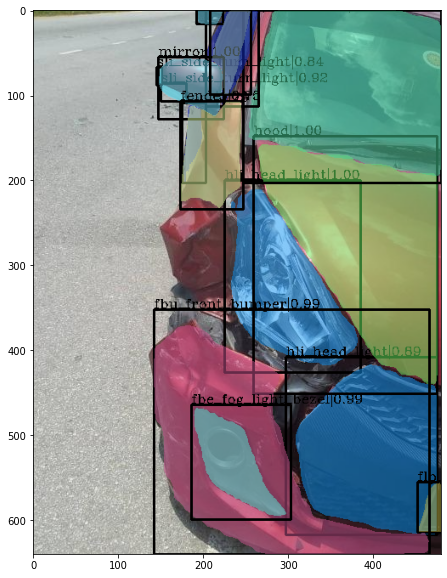

In [13]:
img = cv2.imread(str(path/'images'/data['images'][1]['file_name']))
#print(test['images'][1])
h,w,_ = img.shape
#img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.7)
#img_ = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
print(scores)
print(pred_labels)
plt.figure(figsize=(10,10))
plt.imshow(img_)
print(pred_boxes)

In [7]:
def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

In [22]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.75)
    #print(pred_labels)
    overlap = code.intersection(pred_labels)
    
    if len(overlap) / len(code) < 0.5:
        continue
    
    pseudo_segms = pred_segms

    if len(pseudo_segms) == 0:
        continue
        
    pseudo_data['images'].append(img)
    
    for iteration,segm in enumerate(pseudo_segms):
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = int(pred_labels[iteration]+1)
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
    pseudo_data['categories'] = cp['categories']
    
with open(path/'annotations'/'post_pseudo_carparts_rear.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                                           | 0/13658 [00:00<?, ?it/s]/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13658/13658 [35:30<00:00,  6.41it/s]


In [23]:
pseudo_data = json.load(open(path/'annotations'/'post_pseudo_carparts_rear.json'))
print(len(pseudo_data['images']),len(pseudo_data['annotations']))

6506 180138


In [24]:
def sample(js_data):
    #i = random.choice(js_data['images'])
    num = 3
    imgs = random.sample(js_data['images'],num**2)
    #print(i['id'],i['url'])
    #num = 2 
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,i in enumerate(imgs):
        annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in js_data['annotations'] if a['image_id'] == i['id']]
        image = cv2.imread(str(path/'images'/i['file_name']))
        image = cv2.drawContours(image,annos,-1,(255,0,0),2)
        
        axis[int(idx/num),idx%num].imshow(image)
        axis[int(idx/num),idx%num].set_title(i['id'])
        
    #plt.figure(figsize=(20,10))
    #plt.imshow(image)

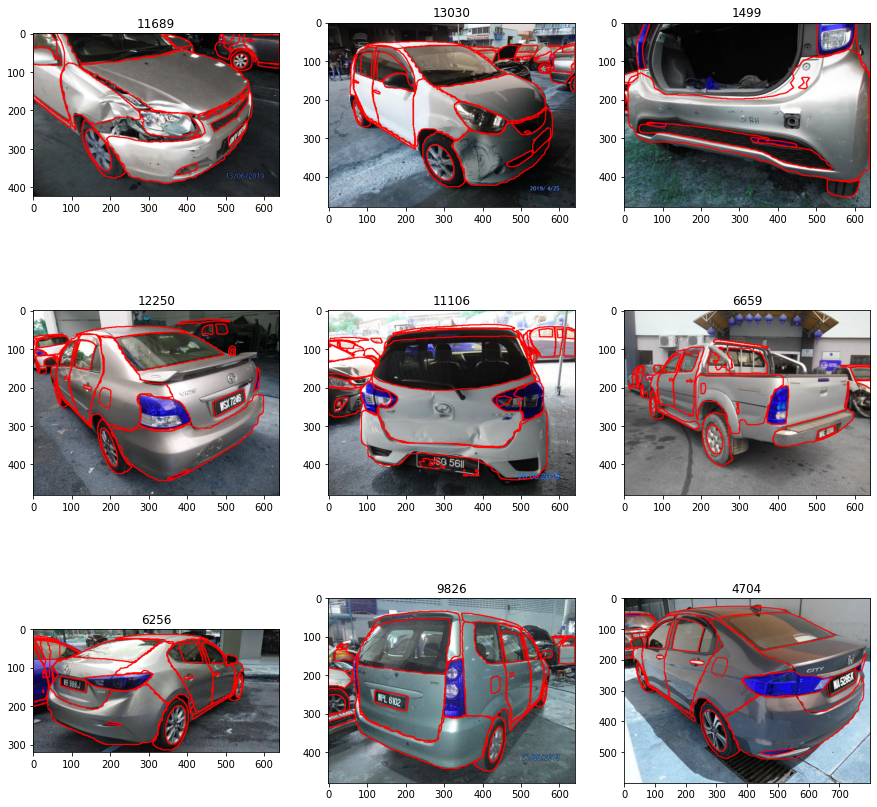

In [26]:
sample(pseudo_data)

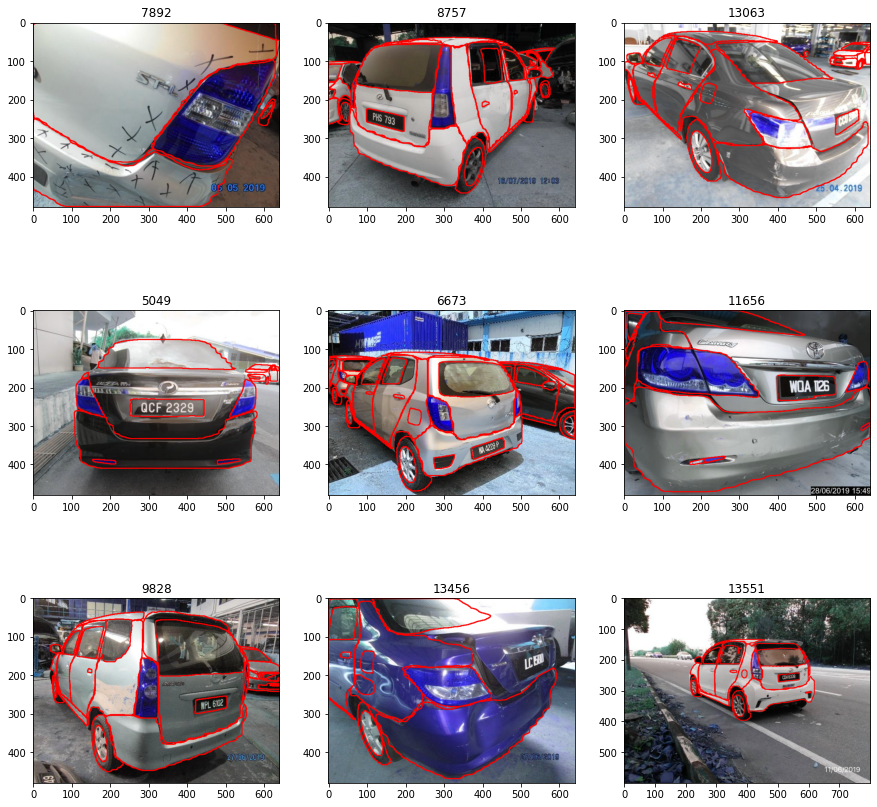

In [28]:
sample(pseudo_data)

In [65]:
dent : 5559/8458

0.657247576259163

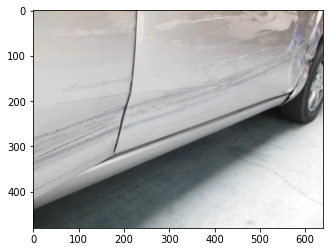

In [8]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))
plt.imshow(image)